In [144]:
# === at the very top of your script ===

# 1) If you haven’t already, install the gradio‐client package:
#    pip install gradio-client

# 2) Monkey‐patch only the boolean‐schema bug in gradio_client.utils
import importlib
try:
    gcu = importlib.import_module("gradio_client.utils")
    _orig_get_type = gcu.get_type
    def _patched_get_type(schema):
        # if the schema is literally True or False, treat it as a generic Any:
        if isinstance(schema, bool):
            return "Any"
        return _orig_get_type(schema)
    gcu.get_type = _patched_get_type
except ModuleNotFoundError:
    # gradio-client not installed or vendored differently—skip patch
    pass

# 3) **Remove** your Blocks.get_api_info override entirely—let Gradio build its OpenAPI.
#    Now import Gradio and define your Blocks UI as before.
import gradio as gr
import uuid

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
import collections
import random
import imageio
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import trimesh
import os
from sklearn.preprocessing import MinMaxScaler
import imageio
import matplotlib.pyplot as plt

In [133]:
class Sculpt3DEnv:
    def __init__(self, grid_size=20, max_steps=200, manager_update_freq=5):
        """
        3D sculpt environment:
         - NxNxN 'stock' array (True => material present)
         - NxNxN 'shape' array (True => protected shape)
         - A router at (0,0,0).
         - Manager picks subgoals in [0..N^3 -1].
         - Worker picks 6 discrete steps: ±x, ±y, ±z.
        """
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.manager_update_freq = manager_update_freq
        self.reset()

    def reset(self, grid_size=None):
        if grid_size is not None:
            self.grid_size = grid_size
        # Initialize stock to True (material present)
        self.stock = np.ones((self.grid_size,)*3, dtype=bool)
        # Default shape: centered sphere
        self._init_default_shape()
        self.router_pos = np.array([0,0,0], dtype=int)
        self.steps_taken = 0
        self.done = False
        self.subgoal = np.array([self.grid_size//2]*3, dtype=int)
        print("shape voxels =", np.sum(self.shape))
        return self._get_manager_obs(), self._get_worker_obs()

    def _init_default_shape(self):
        self.shape = np.zeros((self.grid_size,)*3, dtype=bool)
        cx = cy = cz = self.grid_size // 2
        r = self.grid_size // 2 - 1
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                for z in range(self.grid_size):
                    if (x-cx)**2 + (y-cy)**2 + (z-cz)**2 <= r*r:
                        self.shape[x,y,z] = True

    def load_from_obj(self, obj_path, scale_fraction=0.5):
        """
        Convert a .obj mesh into the environment's voxel grid,
        scaled to occupy `scale_fraction` of the grid.

        Parameters:
        - obj_path: path to Wavefront .obj file
        - scale_fraction: fraction of grid size to fill (0<scale_fraction<=1)
        """
        # Load mesh and move to origin
        mesh = trimesh.load(obj_path, force='mesh')
        mesh.apply_translation(-mesh.bounds[0])
        # Scale mesh to desired fraction of grid
        grid = self.grid_size
        target_size = grid * scale_fraction
        scale = target_size / np.max(mesh.extents)
        mesh.apply_scale(scale)
        # Center mesh within the grid
        dims = mesh.extents
        offset = (grid - dims) / 2.0
        mesh.apply_translation(offset)
        # Voxel centers
        coords = np.indices((grid,grid,grid)).reshape(3, -1).T + 0.5
        # Determine inside voxels
        inside = mesh.contains(coords)
        # Update environment
        self.shape = inside.reshape((grid,grid,grid))
        self.stock = np.ones_like(self.shape)
        self.router_pos = np.array([0,0,0], dtype=int)
        self.steps_taken = 0
        self.done = False
        self.subgoal = np.array([grid//2]*3, dtype=int)
        print(f"Loaded .obj shape with {np.sum(self.shape)} protected voxels at {scale_fraction*100:.0f}% scale.")
        return self._get_manager_obs(), self._get_worker_obs()
    
    def set_subgoal(self, coord):
        coord = np.clip(coord, 0, self.grid_size-1)
        self.subgoal = coord

    def worker_step(self, action):
        """
        action in [0..5]: 0=+x,1=-x,2=+y,3=-y,4=+z,5=-z
        If shape is cut or OOB => done with penalty.
        If outside stock is removed => small reward.
        """
        if self.done:
            return self._get_worker_obs(), 0.0, True
        move = np.array([0,0,0], dtype=int)
        if action==0: move = np.array([1,0,0])
        elif action==1: move = np.array([-1,0,0])
        elif action==2: move = np.array([0,1,0])
        elif action==3: move = np.array([0,-1,0])
        elif action==4: move = np.array([0,0,1])
        elif action==5: move = np.array([0,0,-1])

        oldp = self.router_pos.copy()
        newp = oldp+move
        reward = 0.0
        # check OOB
        if not np.all((newp>=0)&(newp<self.grid_size)):
            reward -= 5.0
            self.done=True
        else:
            path = [oldp, newp]
            for (vx,vy,vz) in path:
                if self.shape[vx,vy,vz]:
                    # shape => penalty
                    reward -= 5.0
                    self.done=True
                    break
                if self.stock[vx,vy,vz]:
                    self.stock[vx,vy,vz] = False
                    reward += 1.0
            if not self.done:
                self.router_pos = newp

        self.steps_taken+=1
        if self.steps_taken>=self.max_steps:
            self.done=True

        return self._get_worker_obs(), reward, self.done, self.steps_taken

    def manager_reward(self):
        """
        fraction_outside_removed
        difference-based approach
        """
        outside_mask = (self.shape==False)
        outside_total = np.sum(outside_mask)
        outside_removed = outside_total - np.sum(self.stock[outside_mask])
        frac_removed = outside_removed/(outside_total+1e-8)
        return frac_removed

    def manager_done(self):
        return self.done

    def _get_manager_obs(self):
        outside_mask = (self.shape==False)
        outside_total = np.sum(outside_mask)
        outside_removed = outside_total - np.sum(self.stock[outside_mask])
        frac_removed = outside_removed/(outside_total+1e-8)
        rx,ry,rz = self.router_pos
        return np.array([frac_removed, rx, ry, rz], dtype=float)

    def _get_worker_obs(self):
        rx,ry,rz = self.router_pos
        sx,sy,sz = self.subgoal
        return np.array([rx,ry,rz, sx,sy,sz], dtype=float)
    
    def render(self, mode='human'):
        """
        Render the environment.
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.voxels(self.stock, facecolors='blue', edgecolors='k', alpha=0.1)
        ax.voxels(self.shape, facecolors='red', edgecolors='k', alpha=0.5)
        ax.scatter(*self.router_pos, color='yellow', s=100)
        ax.scatter(*self.subgoal, color='green', s=100)
        plt.show()
        plt.close(fig)
        return self.router_pos, self.subgoal

    def record_moves(self, moves, filename='moves.gif'):
        """
        Record the moves made by the router.
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.voxels(self.stock, facecolors='blue', edgecolors='k', alpha=0.1)
        ax.voxels(self.shape, facecolors='red', edgecolors='k', alpha=0.5)
        for move in moves:
            ax.scatter(*move, color='yellow', s=100)
        plt.show()
        plt.close(fig)
        
        # Save the recorded moves as a GIF
        images = []
        for move in moves:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.voxels(self.stock, facecolors='blue', edgecolors='k', alpha=0.1)
            ax.voxels(self.shape, facecolors='red', edgecolors='k', alpha=0.5)
            ax.scatter(*move, color='yellow', s=100)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig('temp.png')
            images.append(imageio.imread('temp.png'))
            plt.close(fig)
        imageio.mimsave(filename, images, fps=10)
        # Clean up temporary files
        os.remove('temp.png')
        return moves

    def close(self):
        """
        Close the environment.
        """
        pass

# Experience replay buffer for DQN
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
    
    def __len__(self):
        return len(self.buffer)

# Manager DQN - sets subgoals for worker
class ManagerAgent:
    def __init__(self, state_dim, action_dim, grid_size):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.grid_size = grid_size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.memory = ReplayBuffer(10000)
        
        # Q-Network for predicting subgoal coordinates
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        # Neural network to estimate Q-values for subgoal coordinates
        inputs = Input(shape=(self.state_dim,))
        x = Dense(128, activation='relu')(inputs)
        x = Dense(128, activation='relu')(x)
        
        # Separate output heads for x, y, z coordinates
        x_coord = Dense(self.grid_size, activation='linear')(x)
        y_coord = Dense(self.grid_size, activation='linear')(x)
        z_coord = Dense(self.grid_size, activation='linear')(x)
        
        model = Model(inputs=inputs, outputs=[x_coord, y_coord, z_coord])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Random subgoal
            return np.random.randint(0, self.grid_size, size=3)
        
        # Predict best subgoal
        x_q, y_q, z_q = self.model.predict(np.array([state]), verbose=0)
        x = np.argmax(x_q[0])
        y = np.argmax(y_q[0])
        z = np.argmax(z_q[0])
        return np.array([x, y, z])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Get target Q-values
        x_target, y_target, z_target = self.target_model.predict(next_states, verbose=0)
        
        # Current Q-values
        x_curr, y_curr, z_curr = self.model.predict(states, verbose=0)
        
        for i in range(self.batch_size):
            if dones[i]:
                x_curr[i, actions[i][0]] = rewards[i]
                y_curr[i, actions[i][1]] = rewards[i]
                z_curr[i, actions[i][2]] = rewards[i]
            else:
                x_curr[i, actions[i][0]] = rewards[i] + self.gamma * np.max(x_target[i])
                y_curr[i, actions[i][1]] = rewards[i] + self.gamma * np.max(y_target[i])
                z_curr[i, actions[i][2]] = rewards[i] + self.gamma * np.max(z_target[i])
        
        self.model.fit(states, [x_curr, y_curr, z_curr], epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Worker DQN - executes low-level actions
class WorkerAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.memory = ReplayBuffer(10000)
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_dim, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_dim, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.action_dim)
        
        act_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(act_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        targets = rewards + self.gamma * np.max(self.target_model.predict(next_states, verbose=0), axis=1) * (1 - dones)
        target_f = self.model.predict(states, verbose=0)
        
        for i in range(self.batch_size):
            target_f[i, actions[i]] = targets[i]
        
        self.model.fit(states, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Hierarchical RL training function
def train_hierarchical_agent(grid_size=8, episodes=1000, manager_update_freq=5, render_every=100):
    env = Sculpt3DEnv(grid_size=grid_size, manager_update_freq=manager_update_freq)
    
    manager = ManagerAgent(state_dim=4, action_dim=3, grid_size=grid_size)
    worker = WorkerAgent(state_dim=6, action_dim=6)
    
    best_reward = -float('inf')
    
    for e in range(episodes):
        manager_obs, worker_obs = env.reset()
        manager_reward_total = 0
        worker_reward_total = 0
        
        all_moves = []
        
        # Manager initially sets a subgoal
        subgoal = manager.act(manager_obs)
        env.set_subgoal(subgoal)
        manager_state = manager_obs
        
        for step in range(env.max_steps):
            # Worker takes action
            worker_action = worker.act(worker_obs)
            next_worker_obs, worker_reward, done, steps_taken = env.worker_step(worker_action)
            print(f"Steps taken before done: {steps_taken}")
            
            all_moves.append(env.router_pos.copy())
            
            # Store worker experience
            worker.remember(worker_obs, worker_action, worker_reward, next_worker_obs, done)
            worker_reward_total += worker_reward
            
            worker_obs = next_worker_obs
            
            # Manager update frequency
            if step % manager_update_freq == 0 or done:
                next_manager_obs = env._get_manager_obs()
                manager_reward = env.manager_reward()
                manager_done = env.manager_done()
                
                # Store manager experience
                manager.remember(manager_state, subgoal, manager_reward, next_manager_obs, manager_done)
                manager_reward_total += manager_reward
                
                # Set new subgoal if not done
                if not manager_done:
                    subgoal = manager.act(next_manager_obs)
                    env.set_subgoal(subgoal)
                    manager_state = next_manager_obs
            
            # Train agents
            worker.replay()
            manager.replay()
            
            if done:
                break
        
        # Update target networks periodically
        if e % 10 == 0:
            worker.update_target_model()
            manager.update_target_model()
        
        print(f"Episode: {e+1}/{episodes}, Worker Reward: {worker_reward_total}, Manager Reward: {manager_reward_total}, Epsilon: {worker.epsilon:.2f}")
        
        # Render periodically
        if (e+1) % render_every == 0:
            print("Rendering episode...")
            env.record_moves(all_moves)
            
        # Save best model
        if manager_reward_total > best_reward:
            best_reward = manager_reward_total
            manager.model.save_weights('manager_model.weights.h5')
            worker.model.save_weights('worker_model.weights.h5')
    
    return manager, worker

In [134]:
# Train the hierarchical RL agent
print("Starting training...")
manager, worker = train_hierarchical_agent(grid_size=5, episodes=10, render_every=50)
print("Training completed.")

Starting training...
shape voxels = 7
shape voxels = 7
Steps taken before done: 1
Steps taken before done: 2
Steps taken before done: 3
Steps taken before done: 4
Steps taken before done: 5
Episode: 1/10, Worker Reward: 0.0, Manager Reward: 0.059322033893277795, Epsilon: 1.00
shape voxels = 7
Steps taken before done: 1
Steps taken before done: 2
Steps taken before done: 3
Steps taken before done: 4
Steps taken before done: 5
Episode: 2/10, Worker Reward: -1.0, Manager Reward: 0.05084745762280954, Epsilon: 1.00
shape voxels = 7
Steps taken before done: 1
Steps taken before done: 2
Steps taken before done: 3
Episode: 3/10, Worker Reward: -3.0, Manager Reward: 0.033898305081873026, Epsilon: 1.00
shape voxels = 7
Steps taken before done: 1
Episode: 4/10, Worker Reward: -5.0, Manager Reward: 0.0, Epsilon: 1.00
shape voxels = 7
Steps taken before done: 1
Steps taken before done: 2
Episode: 5/10, Worker Reward: -3.0, Manager Reward: 0.033898305081873026, Epsilon: 1.00
shape voxels = 7
Steps t

/Users/braeden/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [135]:
# Function to test the trained agents
def test_agent(manager, worker, episodes=5, max_steps_test=200, grid_size=5):
    env = Sculpt3DEnv()
    
    for e in range(episodes):
        manager_obs, worker_obs = env.reset(grid_size=grid_size)
        manager_reward_total = 0
        worker_reward_total = 0
        all_moves = []
        
        # Set initial subgoal
        subgoal = manager.act(manager_obs)
        env.set_subgoal(subgoal)
        
        for step in range(max_steps_test):
            # Worker takes action (exploitation mode)
            worker.epsilon = 0
            worker_action = worker.act(worker_obs)
            next_worker_obs, worker_reward, done, steps_taken = env.worker_step(worker_action)
            all_moves.append(env.router_pos.copy())
            
            worker_reward_total += worker_reward
            worker_obs = next_worker_obs
            
            # Manager update
            if step % env.manager_update_freq == 0 or done:
                next_manager_obs = env._get_manager_obs()
                manager_reward = env.manager_reward()
                manager_reward_total += manager_reward
                
                # Set new subgoal if not done
                if not done:
                    manager.epsilon = 0
                    subgoal = manager.act(next_manager_obs)
                    env.set_subgoal(subgoal)
            
            if done:
                break
        
        print(f"Test Episode: {e+1}/{episodes}, Worker Reward: {worker_reward_total}, Manager Reward: {manager_reward_total}")
        env.record_moves(all_moves, filename=f'test_moves_{e}.gif')
        env.render()


Testing trained agent...
shape voxels = 3071
shape voxels = 7
Test Episode: 1/1, Worker Reward: -5.0, Manager Reward: 0.0


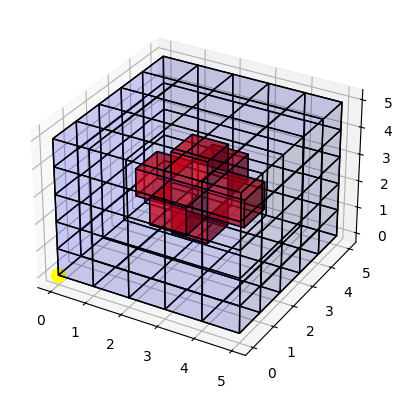

/var/folders/km/9hmy_qv946z1t5m7z35vf6600000gn/T/ipykernel_41719/2745067479.py:187: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('temp.png'))


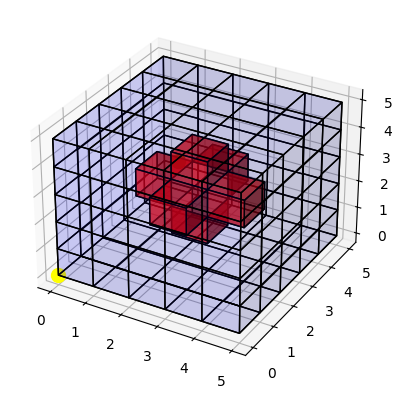

In [136]:
# Test the trained agent
print("Testing trained agent...")
test_agent(manager, worker, episodes=1, max_steps_test=200, grid_size=5)

shape voxels = 3071
Loaded .obj shape with 216 protected voxels at 30% scale.


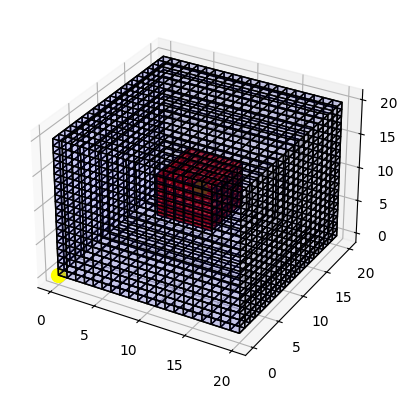

In [137]:
# Test loading from .obj file
env = Sculpt3DEnv(grid_size=20)
env.load_from_obj('tinker.obj', scale_fraction=0.3)
env.render()
env.close()

In [145]:
import gradio as gr
import uuid

# Make sure these are imported or defined above in your file:
# from your_module import Sculpt3DEnv, ManagerAgent, WorkerAgent

def run_model(obj_file, scale_fraction):
    obj_path = obj_file.name
    env = Sculpt3DEnv(grid_size=20)
    _, _ = env.load_from_obj(obj_path, scale_fraction)

    # load pretrained agents
    manager = ManagerAgent(state_dim=4, action_dim=3, grid_size=env.grid_size)
    manager.model.load_weights('manager_model.weights.h5')
    manager.update_target_model()

    worker = WorkerAgent(state_dim=6, action_dim=6)
    worker.model.load_weights('worker_model.weights.h5')
    worker.update_target_model()

    # run one episode
    manager_obs, worker_obs = env._get_manager_obs(), env._get_worker_obs()
    subgoal = manager.act(manager_obs)
    env.set_subgoal(subgoal)
    moves = []

    for step in range(env.max_steps):
        action = worker.act(worker_obs)
        worker_obs, _, done, _ = env.worker_step(action)
        moves.append(env.router_pos.copy())

        if step % env.manager_update_freq == 0 and not done:
            manager_obs = env._get_manager_obs()
            subgoal = manager.act(manager_obs)
            env.set_subgoal(subgoal)

        if done:
            break

    gif_filename = f"run_{uuid.uuid4().hex}.gif"
    env.record_moves(moves, filename=gif_filename)
    return gif_filename

with gr.Blocks() as demo:
    gr.Markdown("## 3D Sculpting with Hierarchical RL")
    with gr.Row():
        obj_input   = gr.File(label="Upload your .OBJ file")
        scale_input = gr.Slider(0.1, 1.0, value=0.5, step=0.1, label="Scale Fraction")
    run_btn    = gr.Button("Run Sculpt")
    gif_output = gr.Image(label="Model Run Animation (GIF)")
    run_btn.click(fn=run_model, inputs=[obj_input, scale_input], outputs=[gif_output])

if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7878

To create a public link, set `share=True` in `launch()`.
